In [0]:
#access kaggle dataset 
!pip install kaggle
#machine learning
!pip install catboost

In [0]:
import sys
import scipy
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import os
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats


In [0]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [0]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip train.csv.zip
!ls

catboost_info  sample_submission.csv  train.csv
sample_data    test.zip		      train.csv.zip
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
catboost_info  sample_submission.csv  train.csv
sample_data    test.zip		      train.csv.zip


In [0]:
#extract train data into a df for manip
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [0]:
#take a look at the 1st 10 
train.head(20)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744
9,3,1.4690999733


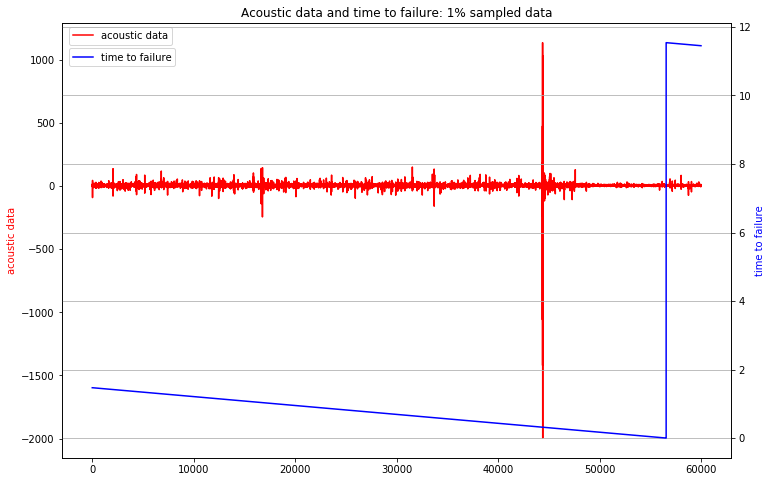

In [0]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:
#Feature eng. - create a function to generate stat features from train data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000
mean,4.519475157932917,6.547788190832376,-149.190941597139442,163.522288438617409,68.297997078886311,0.125830201533653,-11.224603098927293,-2.184779499404052,11.231716328963049,20.321890345649656,170.046245530393321,5.547366504438947,5.750164895071956
std,0.256049485926947,8.503939490256958,265.087983547740237,272.930331447498872,70.532565012634521,0.477901196543982,14.106851749718865,2.346558457187657,2.358067486415371,14.225526173874824,296.887014915214138,1.517037556246679,8.339211436139040
min,3.596313333333333,2.802720142449153,-5515.000000000000000,23.000000000000000,0.648601727651454,-4.091826220725587,-336.000000000000000,-39.000000000000000,9.000000000000000,11.000000000000000,23.000000000000000,4.147706666666667,2.589085218316308
25%,4.349496666666667,4.478637142151063,-154.000000000000000,92.000000000000000,28.090227382235867,-0.040779004942732,-14.000000000000000,-3.000000000000000,10.000000000000000,15.000000000000000,94.000000000000000,5.061843333333334,3.862810034013982
50%,4.522146666666667,5.618797774899163,-111.000000000000000,123.000000000000000,45.816624913747923,0.085619830683749,-10.000000000000000,-2.000000000000000,11.000000000000000,19.000000000000000,127.000000000000000,5.380853333333333,4.781513433258028
75%,4.693350000000001,6.880903553140399,-79.000000000000000,170.000000000000000,78.664201990993135,0.253930302215080,-6.000000000000000,-1.000000000000000,12.000000000000000,23.000000000000000,175.000000000000000,5.748553333333334,5.887947257796146
max,5.391993333333334,153.703569356093254,-15.000000000000000,5444.000000000000000,631.158926834507270,4.219428824355885,-2.000000000000000,0.000000000000000,50.000000000000000,337.000000000000000,5515.000000000000000,32.762073333333333,150.432368254177703


In [0]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.47441934696739}}

In [0]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [0]:
from sklearn.kernel_ridge import KernelRidge

parameters = [{'gamma': np.linspace(0.001, 0.1, 10),
               'alpha': [0.005, 0.01, 0.02, 0.05, 0.1]}]

reg2 = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5, scoring='neg_mean_absolute_error')
reg2.fit(X_train_scaled, y_train.values.flatten())
y_pred2 = reg2.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg2.best_score_))
print(reg2.best_params_)

Best CV score: -2.2046
{'alpha': 0.1, 'gamma': 0.012}


In [0]:
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
import random


fixed_params = {
    'objective': 'regression_l1',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19
}

param_grid = {
    'learning_rate': [0.1, 0.08, 0.05, 0.01],
    'num_leaves': [32, 46, 52, 58, 68, 72, 80, 92],
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
}

best_score = 999
dataset = lgb.Dataset(X_train, label=y_train)  # no need to scale features

for i in tqdm(range(200)):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = lgb.cv(params, dataset, nfold=5, early_stopping_rounds=50,
                    num_boost_round=20000, stratified=False)
    
    if result['l1-mean'][-1] < best_score:
        best_score = result['l1-mean'][-1]
        best_params = params
        best_nrounds = len(result['l1-mean'])

In [0]:
print("Best mean score: {:.4f}, num rounds: {}".format(best_score, best_nrounds))
print(best_params)
reg3 = lgb.train(best_params, dataset, best_nrounds)
y_pred3 = reg3.predict(X_train)

Best mean score: 2.1022, num rounds: 69
{'learning_rate': 0.08, 'num_leaves': 72, 'max_depth': 3, 'feature_fraction': 0.85, 'subsample': 0.85, 'lambda_l1': 0.1, 'lambda_l2': 0.2, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.01, 'objective': 'regression_l1', 'boosting': 'gbdt', 'verbosity': -1, 'random_seed': 19}


<Figure size 432x288 with 0 Axes>

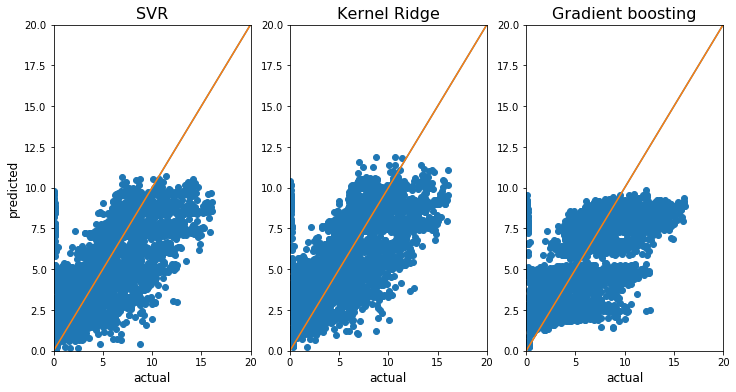

Text(0.5, 1.0, 'GBDT predictions vs actual')

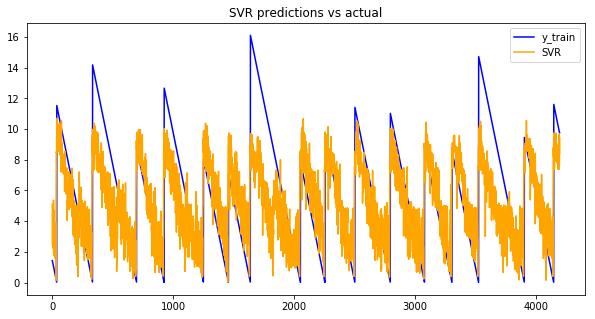

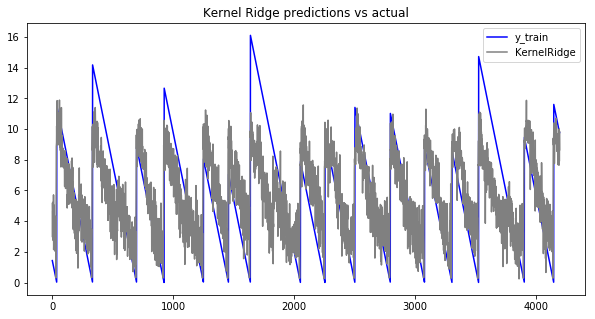

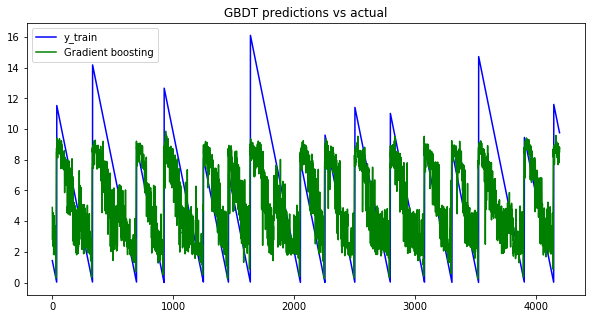

In [0]:
plt.tight_layout()
f = plt.figure(figsize=(12, 6))
f.add_subplot(1, 3, 1)
plt.scatter(y_train.values.flatten(), y_pred1)
plt.title('SVR', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(1, 3, 2)
plt.scatter(y_train.values.flatten(), y_pred2)
plt.title('Kernel Ridge', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(1, 3, 3)
plt.scatter(y_train.values.flatten(), y_pred3)
plt.title('Gradient boosting', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show(block=True)

# second plot
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred1, color='orange', label='SVR')
plt.legend()
plt.title('SVR predictions vs actual')

# third plot
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred2, color='gray', label='KernelRidge')
plt.legend()
plt.title('Kernel Ridge predictions vs actual')

# fourth plot
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred3, color='green', label='Gradient boosting')
plt.legend()
plt.title('GBDT predictions vs actual')